# This jupyter notebook contains the code to set up the simulation sheet for the Mierendoffinsel


In [1]:
import sys
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path+"\\src\\citygml")

from sheet_generation import create_sheet
from scenario_generation import create_scenario, set_yoc
from gml_alkis import get_block, get_groundsurfes

<Axes: >

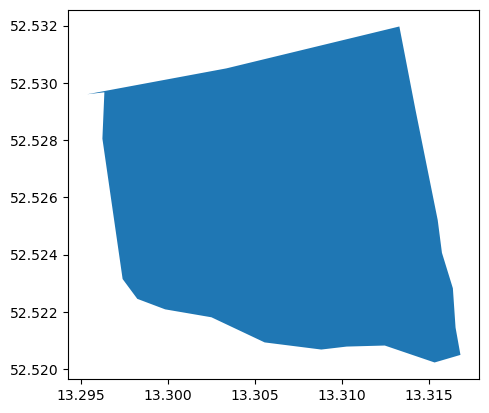

In [5]:
# Set the path to the CityGML files
gml_files = ["LoD2_33_384_5820_1_BE.xml", "LoD2_33_384_5821_1_BE.xml", "LoD2_33_385_5820_1_BE.xml", "LoD2_33_385_5821_1_BE.xml"]

# Load Mierendorff Shape
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the shapefile
# data is obtained from QGIS, the shapefile is a polygon of the Mierendorff island in Berlin
file_path = os.path.join(module_path, 'data' ,'examples' ,'Mierendorff_shape' ,'Mierendorff_shape.shp')

inner_mierendorff = gpd.read_file(file_path)
inner_mierendorff.plot()


In [7]:
# import pandas and geopandas
import pandas as pd
import geopandas as gpd

In [8]:
df_list = []
for gml_file in gml_files: 
    gml_path = os.path.join(module_path, "data", "examples", "gml_data", gml_file)
    df_sheet = create_sheet(gml_path)
    df_list.append(df_sheet)


df = pd.concat(df_list)
# Necessary due do it being a list


In [9]:
# Load data for buildings within blocks: 
block_data_path = os.path.join(module_path, 'data' ,'examples' ,'gml_data' ,'buildings_and_building_parts.csv')
within_blocks = pd.read_csv(block_data_path)
within_blocks.head()

,geometry,coordinates,gml_id,building_part_id,index_right,blknr,bez,bezname,plr,blktypname,ewk,area,datum
0,POLYGON ((190173.32861862011 173162.3613194087...,"[[384976.272, 5820790.551, 32.65], [384977.076...",DEBE3D04YY50000BlO,NaN,28,20050,4,Charlottenburg-Wilmersdorf,4300518,Block,100-999 Einwohner,819.436562,1994/06/01 00:00:00.000
1,POLYGON ((190209.72002693682 173191.6674380649...,"[[385014.416, 5820817.572, 32.036], [385016.05...",DEBE3D04YY50000QXO,NaN,28,20050,4,Charlottenburg-Wilmersdorf,4300518,Block,100-999 Einwohner,173.937359,1994/06/01 00:00:00.000
2,POLYGON ((190209.72002693682 173191.6674380649...,"[[385014.416, 5820817.572, 32.036], [385016.05...",DEBE3D04YY50000QXO,DEBE3DPcFE8lkbYV,28,20050,4,Charlottenburg-Wilmersdorf,4300518,Block,100-999 Einwohner,173.937359,1994/06/01 00:00:00.000
3,POLYGON ((190229.7310809504 173193.26077722237...,"[[385034.496, 5820817.93, 32.036], [385034.49,...",DEBE3D04YY50000QXO,DEBE3DpnBYcjfpwT,28,20050,4,Charlottenburg-Wilmersdorf,4300518,Block,100-999 Einwohner,30.939735,1994/06/01 00:00:00.000
4,POLYGON ((190219.01940630068 173206.1636086045...,"[[385024.595, 5820831.474, 32.036], [385016.24...",DEBE3D04YY50000QXO,DEBE3DwERcC6Wilv,28,20050,4,Charlottenburg-Wilmersdorf,4300518,Block,100-999 Einwohner,142.857381,1994/06/01 00:00:00.000


<Axes: >

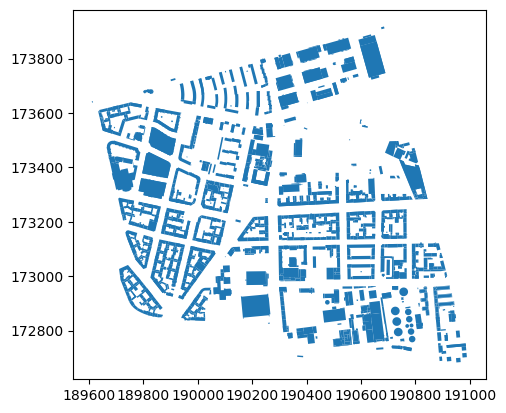

In [23]:
# Convert geometry strings to shapely geometry objects
from shapely import wkt
gdf = within_blocks.copy()
gdf['geometry'] = gdf['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
gdf.plot()

In [6]:
# Get the IDs from the spatial merge
relevant_sheet = df[df['gml_id'].isin(within_blocks['gml_id'])]
relevant_sheet.loc[:,"dg_id"] = range(len(relevant_sheet))

In [14]:
def average_year_from_range(year_range):
    # This function extracts the start and end years from a range, calculates the average, and returns it as an integer
    # "gemischte"
    if isinstance(year_range, str):
        if '-' in year_range:
            start_year, end_year = year_range.split('-')
            average_year = (int(start_year) + int(end_year)) // 2
            return average_year
        elif year_range == "gemischte Baualtersklasse":
            return None 
        elif year_range == "bis 1900": 
            return 1900
        elif year_range == "NaN":
            return None 
    if isinstance(year_range, float):
        if year_range == "":
            return ""
        else:
            return ""
    return int(year_range)  # Handles cases where the year is not a range but a single year



In [15]:


# Define the root folder based on the current working directory
root_folder = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

shape_data_path = os.path.join(root_folder, 'data', 'examples', 'block_shape', '00_block_shape.shp')
shapes = gpd.read_file(shape_data_path)
shapes["blknr"] = shapes["blknr"].astype('int64') 
file_path_age = os.path.join(root_folder, 'data', 'berlin','02_Gebäudealter.csv') 
age_df = pd.read_csv(file_path_age)
bldg_age_shapes =  shapes.merge(age_df, on='blknr') 

blocks_gml = bldg_age_shapes.merge(within_blocks,  on='blknr')

blocks_gml.head()

blocks_gml["year"] = blocks_gml.apply(lambda row: average_year_from_range(row['ueberw_dek']), axis=1)

In [16]:
blocks_gml["year"].value_counts()

year
1905    842
1900    308
1925    237
        231
2013    215
2005    166
1955    124
1985     40
1935      6
Name: count, dtype: int64

In [17]:
# Drop duplicates based on 'gml_id' to keep only the first occurrence
unique_blocks_gml = blocks_gml.drop_duplicates(subset='gml_id')

# Convert to dictionary with 'gml_id' as the key and 'year' as the value
blocks_gml_dict = unique_blocks_gml.set_index('gml_id')['year'].to_dict()

# Display the resulting dictionary
blocks_gml_dict

{'DEBE3D04YY50000Qyp': '',
 'DEBE3D04YY50002bxT': '',
 'DEBE3D04YY500005xe': '',
 'DEBE3D04YY500007aH': '',
 'DEBE3D04YY500007XO': '',
 'DEBE3D04YY50000JJU': '',
 'DEBE3D04YY50000RJv': '',
 'DEBE3D04YY50000NMQ': '',
 'DEBE3D04YY500003H4': '',
 'DEBE3D04YY50000L7H': '',
 'DEBE3D00YYNv0000C7': '',
 'DEBE3D04YY5000071d': '',
 'DEBE3D04YY50002ccC': '',
 'DEBE3D04YY50002cUy': '',
 'DEBE3D04YY50002d0o': '',
 'DEBE3D04YY50000Afw': '',
 'DEBE3D04YY50000A1M': '',
 'DEBE3D04YY50000Cu4': '',
 'DEBE3D04YY50000EA1': '',
 'DEBE3D04YY50002bfE': '',
 'DEBE3D04YY50000Dil': '',
 'DEBE3D04YY50002brW': '',
 'DEBE3D04YY50002bvX': '',
 'DEBE3D04YY50002bvp': '',
 'DEBE3D04YY50002cGN': '',
 'DEBE3D04YY50002cMh': '',
 'DEBE3D04YY50002bTt': '',
 'DEBE3D04YY500005p2': '',
 'DEBE3D04YY50000PWf': '',
 'DEBE3D00YYNv0000Bv': '',
 'DEBE3D04YY500003Z4': '',
 'DEBE3D04YY500005hc': '',
 'DEBE3D04YY500006ii': '',
 'DEBE3D04YY50000NYV': '',
 'DEBE3D04YY50002bqh': '',
 'DEBE3D04AL2vw0000z': '',
 'DEBE3D04YY500008Fe': '',
 

In [18]:
# Map the 'gml_id' in scenario_df to the 'year' using blocks_gml_dict
relevant_sheet.loc[:,"year_of_construction"] = relevant_sheet["gml_id"].map(blocks_gml_dict)

In [24]:
# Turn the building dictionary into a scenario
relevant_sheet.to_csv(r'C:\Users\felix\Programmieren\DVG\TECDEM\data\model_sheets\2024_12_03_Mierendorff_GML.csv')
create_scenario(sheet_file=r'C:\Users\felix\Programmieren\DVG\TECDEM\data\model_sheets\2024_12_03_Mierendorff_GML.csv', scenario_name="2024_12_03_Mierendorff_Baseline", default_building_type = "-")

OSError: Cannot save file into a non-existent directory: 'c:\Users\felix\Programmieren\DVG\TECDEM\src\districtgenerator\data\scenarios'

In [23]:
scenario_df = pd.read_csv(r'C:\Users\felix\Programmieren\districtgenerator\data\scenarios\Mierendorff_Baseline.csv', sep=";",)
scenario_df.head()

,id,building,year,retrofit,area
0,0,AB,1900.0,NaN,6363.253906
1,1,AB,1905.0,NaN,6519.537598
2,2,IWU Transport,1905.0,NaN,23.834473
3,3,AB,1905.0,NaN,1569.339844
4,4,AB,1905.0,NaN,4516.176270


In [ ]:
print(f"There rare {len(relevant_sheet.building_type_gml.value_counts())} different building types in the dataset.")

There rare 53 different building types in the dataset.
